In [22]:
import numpy as np
from matplotlib import pyplot as plt
import os
import h5py
import pickle
import re
import pdb
from collections import defaultdict, Counter
from nltk.corpus import stopwords
%matplotlib inline

In [44]:
path = '/dfs/scratch0/wleif/Reddit/clean_comments/'
subreddits = os.listdir(path)
subreddits = ['news']

In [45]:
#%%timeit -n1 -r1
print_every = 1

usr2ind = {}
ind2usr = {}
n_users = 0

sub2ind = {}
ind2sub = {}
n_subs = len(subreddits)

users = {}

for i, subreddit in enumerate(subreddits):
    sub2ind[subreddit] = i
    ind2sub[i] = subreddit
    with open(path+subreddit+'.tsv', 'r') as df:
        #raw_data = np.genfromtxt(df, dtype=str, delimiter='\t')
        for row in df:
            user = row.split('\t')[-5]
            if user not in usr2ind:
                ind2usr[n_users] = user
                usr2ind[user] = n_users
                users[n_users] = defaultdict(int)
                n_users += 1
            users[usr2ind[user]][i] += 1

    
    if i % print_every == 0:
        print "Finished %d" % (i+1)

Finished 1


In [46]:
'''

Some analytics

'''

counter = [0.0] * n_subs
r_counter = [0.0] * n_subs
n_posts = 0
thresh_sub = 0
thresh_posts = 25
user_pool = []

# counts the number of subreddits for which the user has posted > min_span times
def robust_count(d, min_spans = 5):
    return sum([1 if v >= min_spans else 0 for v in [v for v in d.values()] ])
        
for k, v in users.iteritems():
    n_posts += sum([uv for _, uv in v.iteritems()]) # count number of posts user made total
    for i in xrange(len(v)):
        counter[i] += 1
    for i in xrange(robust_count(v, thresh_posts)):
        r_counter[i] += 1
    if robust_count(v, thresh_posts) > thresh_sub:
        user_pool.append(k)
percents = [n / n_users for n in r_counter]
for i, percent in enumerate(percents):
    print "nsubs: %d, percent: %.3f, robust count (more than %d posts): %d, full count: %d" % \
            (i, percent, thresh_posts, r_counter[i], counter[i])
    
user_pool = set(user_pool)
pruned_usr2ind = {}
pruned_ind2usr = {}
for user in user_pool:
    pruned_ind2usr[len(pruned_usr2ind)] = ind2usr[user]
    pruned_usr2ind[ind2usr[user]] = len(pruned_usr2ind)
    
print "Total number of users: %d, Number of selected users: %d" % (n_users, len(user_pool))
print "Total number of posts: %d" % n_posts

nsubs: 0, percent: 0.066, robust count: 23906, full count: 363300
Total number of users: 363300, Number of selected users: 23906
Total number of posts: 3357895


In [47]:
'''

Get the posts for the users that selected population of users (user_pool)

'''

print_every = [4.,1.]
posts = [[[] for x in xrange(n_users)] for y in xrange(n_subs)]

for i, subreddit in enumerate(subreddits):
    nrows = sum(1 for row in open(path+subreddit+'.tsv', 'r'))
    with open(path+subreddit+'.tsv', 'r') as df:
        sub_ind = sub2ind[subreddit]
        for j, row in enumerate(df):
            data = row.split('\t')
            if data[-5] in pruned_usr2ind:
                user = pruned_usr2ind[data[-5]]
                posts[sub_ind][user].append((data[-1], data[1]))

            if j % int(nrows/print_every[0]) == 0:
                print '\t%.2f' % (j/float(nrows))

    if i % print_every[1] == 0:
        print "Finished %d" % (i+1)

	0.00
	0.25
	0.50
	0.75
	1.00
Finished 1


In [81]:
'''

Build vocab

'''


outfile = '/dfs/scratch0/wangalex/rmn/reddit5'

freqs = defaultdict(int)
doc_freqs = {}
special = ['<EOS>', '<UNK>', '<SPECIAL>', '<URL>']
lens = []
max_len = 0

_digits = re.compile('\d')
def numify(s):
    return bool(_digits.search(s))

print "Sorting by date and gathering vocab..."
for i in xrange(n_subs):
    for j in xrange(n_users):
        if posts[i][j] is []:
            continue
        posts[i][j].sort(key=lambda tup:tup[-1])
        for post,_ in posts[i][j]:
            #clean_words = re.sub(r"[0-9]{1,}", "<NUM>", re.sub(r"<(.+?)>", "", post)).strip().split()
            clean_words = ["<NUM>" if numify(w) else w for w in post.strip().split()]
            for word in clean_words:
                if word not in doc_freqs:
                    doc_freqs[word] = [0 for x in xrange(n_subs)]
                doc_freqs[word][i] = 1
                freqs[word] += 1
            lens.append(len(clean_words))
            max_len = max(max_len, len(clean_words))

doc_freqs = {word:sum(freq) for word, freq in doc_freqs.iteritems()}

Sorting by date and gathering vocab...


In [76]:
'''

Prune vocab
    - break up into cells because each operation is pretty costly
    
'''

min_doc_appearances = 1
remove_top_k = 0 # TODO: maybe up this?
max_vocab_size = 10000
stops = stopwords.words('english')

In [82]:
# pruning vocab borrowed from Yoon Kim
vocab = [(word, count) for word, count in freqs.iteritems()]
vocab.sort(key = lambda x: x[1], reverse = True)

In [83]:
no_common_words = [pair[0] for pair in vocab[remove_top_k:] if pair[0] not in stops]

In [84]:
min_doc_words = filter(lambda x: doc_freqs[x] >= min_doc_appearances, no_common_words)

In [87]:
if max_vocab_size <= 1:
    stop_pt = int(max_vocab_size * len(min_doc_words))
else:
    stop_pt = max_vocab_size# - len(special)
pruned = min_doc_words[:stop_pt]

word2ind = {}
ind2word = {}
ind = 1 # start with 1 for easy masking
for word in special+pruned:
    if word not in word2ind:
        word2ind[word] = ind
        ind2word[ind] = word
        ind += 1

print "Writing vocab..."
with open(outfile+'.vocab.txt', 'w') as f:
    f.write("Word Index Count DocFreq\n")
    words = [(word, idx) for word, idx in word2ind.iteritems()]
    words.sort(key = lambda x: x[1])
    for word, idx in words:
        if word in freqs:
            f.write("%s %d %d %d\n" % (word, idx, freqs[word], doc_freqs[word]))
        else:
            f.write("%s %d %d %d\n" % (word, idx, -1, -1))

with open(outfile+'.vocab.pkl', 'w') as f:
    pickle.dump((word2ind, ind2word), f)

print '\tFull vocab size: %d, pruned vocab size: %d' % (len(vocab), len(word2ind))

Writing vocab...
	Full vocab size: 335348, pruned vocab size: 10001


In [ ]:
'''

Generate the data

'''

span_data = []
sub_data = []
user_data = []

max_len = min(max_len, 116)

lengths = []
unks = []

unk = word2ind['<UNK>']

for i in xrange(n_subs):
    #sub = np.array([i], dtype=np.int32)
    for j in xrange(n_users):
        if not posts[i][j]:
            continue
        #user = np.array([j], dtype=np.int32)
        spans = []
        masks = []
        for post,_ in posts[i][j]:
            #clean_words = re.sub(r"[0-9]{1,}", "<NUM>", re.sub(r"<(.+?)>", "", post)).strip().split()
            clean_words = ["<NUM>" if numify(w) else w for w in re.sub(r"<(.+?)>", "", post).strip().split()]
            if not clean_words:
                continue
            span = [word2ind[word] if word in word2ind else unk for word in clean_words[:max_len]] + \
                    [0]*(max_len-len(clean_words))
            sub_data.append(i)
            user_data.append(j)
            span_data.append(span)
            
            # analytics: number of unknowns and length of phrases
            unks.append(sum(filter(lambda x: x == unk, span)))
            lengths.append(len(span))

sub_data = np.array(sub_data, dtype=np.int32)        
user_data = np.array(user_data, dtype=np.int32)
span_data = np.array(span_data, dtype=np.int32)
unks = np.array(unks, dtype=np.float32) / unk
lengths = np.array(lengths, dtype=np.float32)
print "Mean %% unk: %.3f, var: %.3f" % (np.mean(unks / lengths), np.var(unks/lengths))
print "Max: %.3f, Min: %.3f" % (np.max(unks / lengths), np.min(unks / lengths))

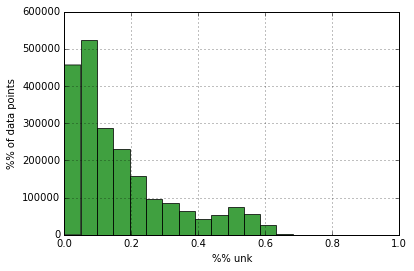

In [101]:
# the histogram of the data
n, bins, patches = plt.hist(unks/lengths, 20, normed=0, facecolor='green', alpha=0.75)
plt.xlabel('%% unk')
plt.ylabel('%% of data points')
plt.grid(True)
plt.show()

In [57]:
'''

Write data to pickles and stuff

'''

metadata_path = '/dfs/scratch0/wangalex/rmn/reddit_news_meta.pkl'
span_path = '/dfs/scratch0/wangalex/rmn/reddit_news_spans.hdf5'

pickle.dump((word2ind, pruned_ind2usr, ind2sub), open(metadata_path, 'wb'))

with h5py.File(span_path, "w") as f:
    f['subs'] = sub_data
    f['user'] = user_data
    f['spans'] = span_data

In [102]:
'''

Build word2vec pretrained embeddings

'''

word_vecs = {}
vec_file = '/dfs/scratch0/gigawordvecs/GoogleNews-vectors-negative300.bin'
word2vec_path = '/dfs/scratch0/wangalex/rmn/glove.We'

with open(vec_file, "rb") as f:
    header = f.readline()
    vocab_size, layer1_size = map(int, header.split())
    binary_len = np.dtype('float32').itemsize * layer1_size
    for line in xrange(vocab_size):
        word = []
        while True:
            ch = f.read(1)
            if ch == ' ':
                word = ''.join(word)
                break
            if ch != '\n':
                word.append(ch)
        if word in word2ind:  
            word_vecs[word] = np.fromstring(f.read(binary_len), dtype='float32')
        else:
            f.read(binary_len)

In [103]:
# extra first row is because of how I'm constructing masks...
embed = np.random.uniform(-0.25, 0.25, (len(word2ind), len(word_vecs.values()[0])))
embed[0] = 0
for word, vec in word_vecs.items():
    embed[word2ind[word]-1] = vec
    
print "\tLoaded %d vectors" % len(word_vecs)
with h5py.File('/dfs/scratch0/wangalex/rmn/w2v.hdf5', 'w') as f:
    f['w2v'] = embed

	Loaded 9844 vectors


In [106]:
span_data.shape

(2158693, 116)

In [104]:
test = [word for word in word2ind if word not in word_vecs]
print test
print sorted([freqs[word] for word in test])

['non-violent', 'scalia', 'for-profit', 'atf', 'wtc', 'dorian', 'elon', 'anti-gun', 'mra', 'co-pilot', 'greenwald', 'blm', 'judgements', 'e-cigs', 'axe', 'stormfront', 'middle-class', '<SPECIAL>', 'inmarsat', 'atc', 'emts', 'travelling', 'long-term', 'leos', 'nra', 'r/worldnews', 'and/or', 'knee-jerk', 't-shirt', 'subreddit', 'licence', 'downvote', 'liberia', 'so-called', 'anti-gay', 'self-righteous', 'scotus', 'colour', 'downvotes', 'downvoted', 'downvoting', 'scotsman', 'monsanto', 'pro-gun', 'crimea', 'self-defense', 't-mobile', 'dorner', 'r/politics', 'feinstein', 'zimmerman', 'aint', 'ccw', 'offence', 'non-profit', '<EOS>', 'i.e', 'co-workers', 'kluwe', 'ffl', 'gmos', 'grey', 'wasnt', 'u.s', 'labour', 'part-time', '<URL>', 'fdr', 'b/c', 'acars', 'redditors', 'non-issue', 'p.s', 'upvoting', 'well-being', 'welp', 'upvoted', 'upvotes', 'e-mail', 'non-lethal', 'foia', 'sjw', 'snowden', '<UNK>', 'doj', 'short-term', 'trayvon', 'favour', 'ftfy', 'cancelled', 'blasio', 'defence', 'twc', 